## Predict price at next period with LSTM and Keras as a Classification


In [51]:
import sys
import time
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY

import mysql.connector
from mysql.connector import errorcode

import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
 
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, normalize, scale

print(tf.__version__)
print(sys.version)

# https://mapr.com/blog/deep-learning-tensorflow/


1.0.0
3.5.4 |Anaconda custom (x86_64)| (default, Sep 21 2017, 18:03:17) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [52]:
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam, adagrad
from keras import backend as K

from ittutils import ittconnection, get_resampled, get_raw_price, get_raw_volume

### Get price and volume timeseries from Staging DB 


In [53]:
db_connection = ittconnection('prodcopy')
print(db_connection)

transaction_coin = 'BTC'  # ETH
counter_coin = 2   #0 - btc

#resample_period = 60

raw_price_ts = get_raw_price(db_connection, transaction_coin, counter_coin)
raw_volume_ts = get_raw_volume(db_connection, transaction_coin, counter_coin)

raw_price_ts["volume"] = raw_volume_ts


In [54]:
raw_price_ts.tail(5)
# Volume - is that volume at a sec? at a day?

,price,volume
timestamp,,
2018-03-20 12:55:45.707080,856399994190,2.785980e+07
2018-03-20 12:56:48.443560,857558120000,2.790459e+07
2018-03-20 12:57:50.120800,856182800000,2.792577e+07
2018-03-20 12:58:51.553890,856000000000,2.793325e+07
2018-03-20 12:59:53.037600,856000000000,2.793368e+07


### Cut the bad data from the beginning + resample

In [55]:
price_ts = raw_price_ts  # remove gaps
price_ts[pd.isnull(price_ts["price"])] = None

# resample (for smoothing) and normalize (for learning)
res_period = '15min'
data_ts = price_ts.resample(rule=res_period).mean()
data_ts['price_var'] = price_ts['price'].resample(rule=res_period).var()
data_ts['volume_var'] = price_ts['volume'].resample(rule=res_period).var()
data_ts.tail(10)


,price,volume,price_var,volume_var
timestamp,,,,
2018-03-20 10:30:00,8.452440e+11,2.817030e+07,1.167633e+18,9.795944e+08
2018-03-20 10:45:00,8.468473e+11,2.795625e+07,9.090742e+17,5.256065e+09
2018-03-20 11:00:00,8.458260e+11,2.778576e+07,1.043926e+18,7.683994e+06
2018-03-20 11:15:00,8.486578e+11,2.783258e+07,1.834107e+19,5.274958e+09
2018-03-20 11:30:00,8.532077e+11,2.796215e+07,8.966694e+17,5.668400e+09
2018-03-20 11:45:00,8.510664e+11,2.766230e+07,1.055799e+18,3.581604e+09
2018-03-20 12:00:00,8.484000e+11,2.745602e+07,3.199999e+17,1.528403e+07
2018-03-20 12:15:00,8.487872e+11,2.742552e+07,6.329974e+17,6.512221e+08
2018-03-20 12:30:00,8.512893e+11,2.741461e+07,4.763081e+17,1.970656e+08


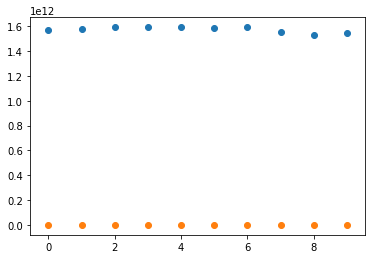

In [56]:
cutoff=10
plt.scatter(x=range(cutoff), y=data_ts['price'].head(cutoff))
plt.scatter(x=range(cutoff), y=data_ts['volume'].head(cutoff))



In [57]:
# cut empty ts from the beginning and interpolate the rest
data_ts = data_ts.tail(len(price_ts)-cutoff)
data_ts = data_ts.interpolate() 
data_ts.tail(10)

,price,volume,price_var,volume_var
timestamp,,,,
2018-03-20 10:30:00,8.452440e+11,2.817030e+07,1.167633e+18,9.795944e+08
2018-03-20 10:45:00,8.468473e+11,2.795625e+07,9.090742e+17,5.256065e+09
2018-03-20 11:00:00,8.458260e+11,2.778576e+07,1.043926e+18,7.683994e+06
2018-03-20 11:15:00,8.486578e+11,2.783258e+07,1.834107e+19,5.274958e+09
2018-03-20 11:30:00,8.532077e+11,2.796215e+07,8.966694e+17,5.668400e+09
2018-03-20 11:45:00,8.510664e+11,2.766230e+07,1.055799e+18,3.581604e+09
2018-03-20 12:00:00,8.484000e+11,2.745602e+07,3.199999e+17,1.528403e+07
2018-03-20 12:15:00,8.487872e+11,2.742552e+07,6.329974e+17,6.512221e+08
2018-03-20 12:30:00,8.512893e+11,2.741461e+07,4.763081e+17,1.970656e+08


In [58]:
data_ts.min(axis=0)


price         6.065558e+11
volume        1.718162e+07
price_var     0.000000e+00
volume_var    8.768249e+02
dtype: float64

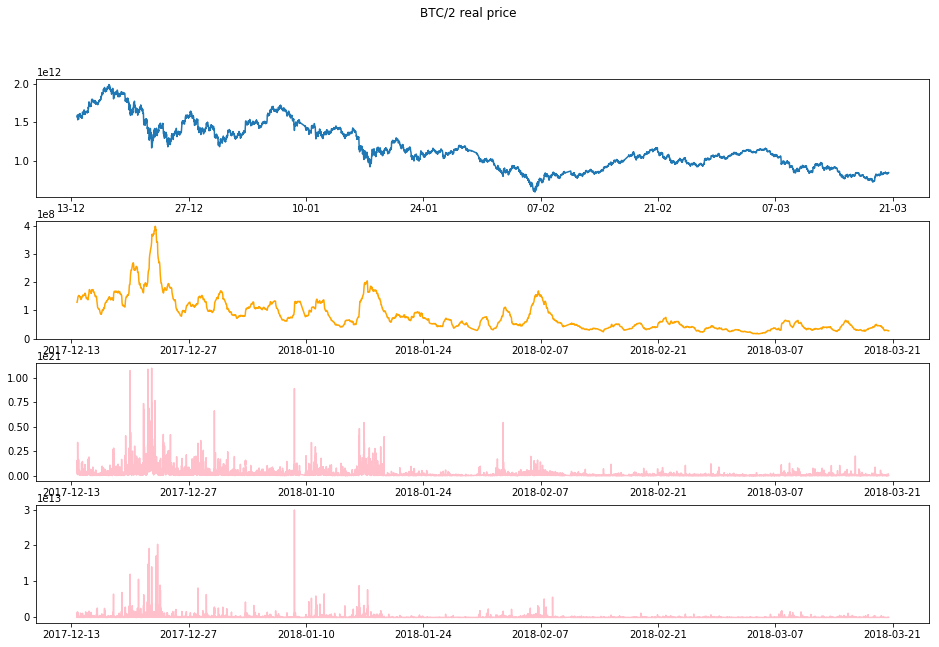

In [59]:
# visually inspect the price and volume
fig, [ax1,ax2,ax3,ax4] = plt.subplots(nrows=4, ncols=1, figsize=(16,10))
fig.suptitle("%s/%d real price" % (transaction_coin, counter_coin))
ax1.xaxis.set_major_formatter(DateFormatter("%d-%m"))
ax1.plot(data_ts['price'])
ax2.plot(data_ts['volume'], color='orange')
ax3.plot(data_ts['price_var'], color='pink')
ax4.plot(data_ts['volume_var'], color='pink')
plt.show()


In [60]:
#print(resampl_ts.shape)
print(data_ts.shape)



(9298, 4)


## Helper functions to convert ts into dataset

In [61]:

# REGRESSION: dataset for regression: split one continues timeseries inro many subsets by striding
def regression_dataset_from_ts(data_df, win_size, stride, future, label_type):

    n = len(data_df)
    num_examples = int((n-win_size)/stride)
    
    # (4968, 96, 1)
    predictors = data_df.shape[1]  # make prediction based on multivatiate ts, price and volume
    
    data_set = np.zeros([num_examples, win_size, predictors])
    labels = np.zeros([num_examples,1])
    prices = np.zeros([num_examples,1])

    for ex in range(0,num_examples):
        one_example_0 = data_df[ex:ex+win_size]['price'].values.reshape([-1,1])
        one_example_1 = data_df[ex:ex+win_size]['volume'].values.reshape([-1,1])
        one_example_2 = data_df[ex:ex+win_size]['price_var'].values.reshape([-1,1])
        one_example_3 = data_df[ex:ex+win_size]['volume_var'].values.reshape([-1,1])
        last_price = one_example_0[-1,0]
        
        data_set[ex,:,0] = one_example_0[:,0]
        data_set[ex,:,1] = one_example_1[:,0]
        data_set[ex,:,2] = one_example_2[:,0]
        data_set[ex,:,3] = one_example_3[:,0]
        

        future_prices = data_df[ex+win_size:ex+win_size+future]['price'].values
        open_price = future_prices[0]
        close_price = future_prices[-1]
        price_return = close_price - open_price
        percentage_return = 1 - (last_price - price_return) / last_price
        
        if label_type=="price":
            label = open_price
            
        if label_type=="return":
            label = price_return

        delta = 0.03
        if label_type=="percent_return":
            label = 0 if (abs(percentage_return)<delta) else np.sign(percentage_return)      
        
        
        labels[ex,:] = label
        prices[ex,:] = open_price
        
    return data_set, labels, prices


def classification_dataset_from_ts(data_df, win_size, stride, future, delta):

    n = len(data_df)
    num_examples = int((n-win_size)/stride)
    
    # (4968, 96, 1)
    predictors = data_df.shape[1]  # make prediction based on multivatiate ts, price and volume
    
    data_set = np.zeros([num_examples, win_size, predictors])
    labels = np.zeros([num_examples,3])
    prices = np.zeros([num_examples,1])

    for ex in range(0,num_examples):
        one_example_0 = data_df[ex:ex+win_size]['price'].values.reshape([-1,1])
        one_example_1 = data_df[ex:ex+win_size]['volume'].values.reshape([-1,1])
        one_example_2 = data_df[ex:ex+win_size]['price_var'].values.reshape([-1,1])
        one_example_3 = data_df[ex:ex+win_size]['volume_var'].values.reshape([-1,1])
        last_price = one_example_0[-1,0]

        future_prices = data_df[ex+win_size:ex+win_size+future]['price'].values
        open_price = future_prices[0]
        close_price = future_prices[-1]
        price_return = close_price - open_price
        percentage_return = 1 - (last_price - price_return) / last_price
        
        label = 0 if (abs(percentage_return)<delta) else np.sign(percentage_return)
        
        data_set[ex,:,0] = one_example_0[:,0]
        data_set[ex,:,1] = one_example_1[:,0]
        data_set[ex,:,2] = one_example_2[:,0]
        data_set[ex,:,3] = one_example_3[:,0]
        
        prices[ex,:] = open_price
        
        # 0 - same / 1 - up / 2 - down
        if label == 0:
            labels[ex,0] = 1
        elif label == 1:
            labels[ex,1] = 1
        elif label == -1:
            labels[ex,2] = 1
                
    return data_set, labels, prices

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) /  predictions.shape[0])

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 


# CLASSIFICATION

## Create a dataset by converting ts into matrix (X,Y)

In [80]:
# normalize to 0 - 1
#price_ts =  ((price_ts - price_ts.mean()) / (price_ts.max() - price_ts.min()) )

# make it more then one
#price_ts = price_ts + abs(price_ts.min(axis=0))

# get the first part as a training and last part as test (not, right, has to be changed!)
train_num = int(len(data_ts) * 0.8)
test_num = len(data_ts) - train_num
             
ts_train = data_ts.head(train_num)
ts_test = data_ts.tail(test_num)

win_size = 128 # do prediction based on history
future = 42    # predict a price return in future timepoints (6h?)
delta = 0.04  # consider UP if last price has been changed by more then delta persents

# convert linear ts to a numpy array of number of training examples
X_train, Y_train, y_tr_price = classification_dataset_from_ts(data_df=ts_train, win_size=win_size, stride=1, future=future, delta=delta)

X_test, Y_test, y_tst_price = classification_dataset_from_ts(data_df=ts_test, win_size=win_size, stride=1, future=future, delta=delta)



In [81]:
X_train.shape

(7310, 128, 4)

### Normalize dataset

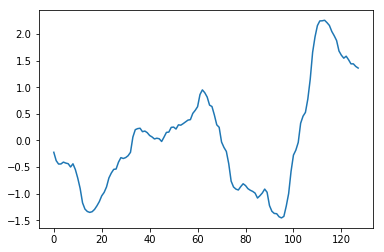

In [99]:
plt.plot(X_train[30,:,1])


In [100]:
'''
for example in range(X_train.shape[0]):
    X_train[example,:,0] = scale(X_train[example,:,0])
    X_train[example,:,1] = scale(X_train[example,:,1])
    X_train[example,:,2] = scale(X_train[example,:,2])
    X_train[example,:,3] = scale(X_train[example,:,3])

for example in range(X_test.shape[0]):
    X_test[example,:,0] = scale(X_test[example,:,0])
    X_test[example,:,1] = scale(X_test[example,:,1])
    X_test[example,:,2] = scale(X_test[example,:,2])
    X_test[example,:,3] = scale(X_test[example,:,3])
'''
# ((price_ts - price_ts.mean()) / (price_ts.max() - price_ts.min()) )
# we normalize to the last element in the exaple set to make algorithm to catch patter more aeasily

for example in range(X_train.shape[0]):
    X_train[example,:,0] = (X_train[example,:,0] - X_train[example,-1,0]) / (np.max(X_train[example,:,0]) - np.min(X_train[example,:,0]))
    X_train[example,:,1] = (X_train[example,:,1] - X_train[example,-1,1]) / (np.max(X_train[example,:,1]) - np.min(X_train[example,:,1]))
    X_train[example,:,2] = (X_train[example,:,2] - X_train[example,-1,2]) / (np.max(X_train[example,:,2]) - np.min(X_train[example,:,2]))
    X_train[example,:,3] = (X_train[example,:,3] - X_train[example,-1,3]) / (np.max(X_train[example,:,3]) - np.min(X_train[example,:,3]))


for example in range(X_test.shape[0]):
    X_test[example,:,0] = (X_test[example,:,0] - X_test[example,-1,0]) / (np.max(X_test[example,:,0]) - np.min(X_test[example,:,0]))
    X_test[example,:,1] = (X_test[example,:,1] - X_test[example,-1,1]) / (np.max(X_test[example,:,1]) - np.min(X_test[example,:,1]))
    X_test[example,:,2] = (X_test[example,:,2] - X_test[example,-1,2]) / (np.max(X_test[example,:,2]) - np.min(X_test[example,:,2]))
    X_test[example,:,3] = (X_test[example,:,3] - X_test[example,-1,3]) / (np.max(X_test[example,:,3]) - np.min(X_test[example,:,3]))



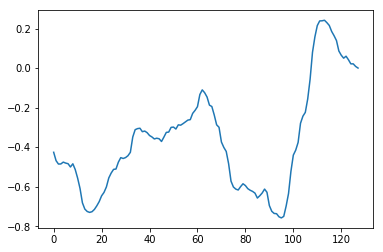

In [101]:
plt.plot(X_train[30,:,1])

### Color the price plot according to label

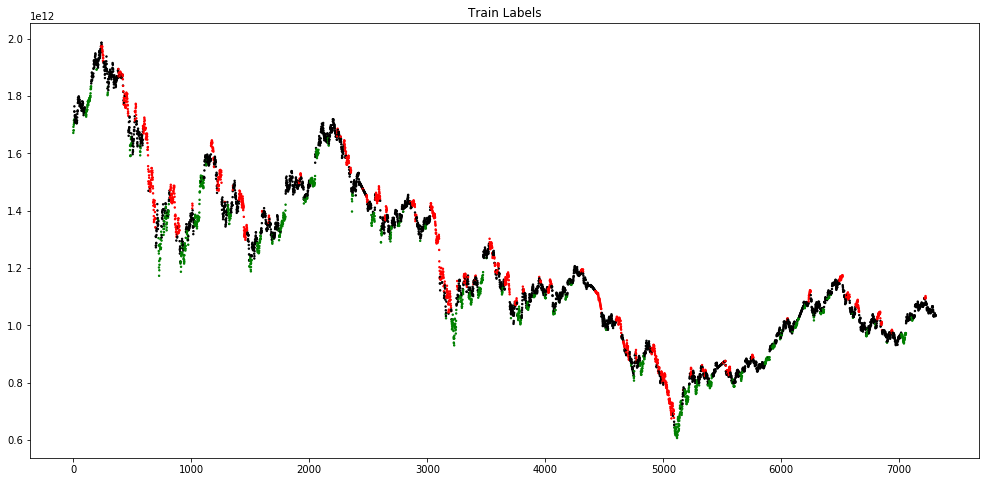

In [102]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(17,8))

ax1.set_title("Train Labels")    
color_label = []
for p in Y_train:  
    if p[1] == 1:
        color = 'green'
    elif p[2] == 1:
        color = 'red' 
    else:
        color = 'black'
    color_label.append(color)

ax1.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=color_label, s=2)

plt.show()

In [103]:

n_time_features = X_train.shape[1]
classes = Y_train.shape[1]
m_test = X_test.shape[0]
m_train = X_train.shape[0]


In [104]:
X_train = X_train.astype(dtype=np.float32)
X_test = X_test.astype(dtype=np.float32)


print(X_train.shape)
print(Y_train.shape)
#print("Y train first  = ")
#print( str(Y_train[0:3,]))

print(X_test.shape)
print(Y_test.shape)

print(" m_train %d, m_test %d, n_features %d, classes %d" % (m_train, m_test, n_time_features, classes ))
  

(7310, 128, 4)
(7310, 3)
(1732, 128, 4)
(1732, 3)
 m_train 7310, m_test 1732, n_features 128, classes 3


# KERAS
The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions 

(N, W, F) where
- N is the number of training sequences, 
- W is the sequence length and 
- F is the number of features of each sequence

network structure of [1, 50, 100, 1] where 
- 1 input layer (consisting of a sequence of size 50) which feeds into an LSTM layer with 50 neurons, 
- that in turn feeds into another LSTM layer with 100 neurons 
- which then feeds into a fully connected normal layer of 1 neuron with a linear activation function which will be used to give the prediction of the next time step.

<img src="images/rnn.jpeg" style="width:600;height:400px;">

In [105]:
#layers = [1, win_size, 100, 1]


data_dim = 4
timesteps = win_size
num_classes = 3

def build_model():
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()

    model.add(
        LSTM(
            90, 
            return_sequences=True,
            input_shape=(timesteps, data_dim),
            dropout=0.2
        )
    )  # returns a sequence of vectors of dimension 32
    
    #model.add(LSTM(60, return_sequences=True, dropout=0.2))  # returns a sequence of vectors of dimension 32
    
    model.add(LSTM(30, dropout=0.2))  # return a single vector of dimension 32
    model.add(Dense(num_classes, activation='softmax'))


    optimizer = adagrad(lr=0.005)
    
    start = time.time()
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [106]:
# epoch = one forward pass and one backward pass of all the training examples

# batch size = the number of training examples in one forward/backward pass. 
#              The higher the batch size, the more memory space you'll need.

# if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

epochs  = 20  # 100

model = build_model()

history = model.fit(
    X_train,
    Y_train,
    batch_size=64,
    epochs=epochs,
    validation_split=0.15)





> Compilation Time :  0.04374384880065918
Train on 6213 samples, validate on 1097 samples
Epoch 1/20
6213/6213 [==============================] - 128s 21ms/step - loss: 0.9576 - acc: 0.5939 - val_loss: 0.7557 - val_acc: 0.7603
Epoch 2/20
6213/6213 [==============================] - 102s 16ms/step - loss: 0.9462 - acc: 0.5978 - val_loss: 0.8261 - val_acc: 0.7603
Epoch 3/20
6213/6213 [==============================] - 119s 19ms/step - loss: 0.9414 - acc: 0.5986 - val_loss: 0.7687 - val_acc: 0.7539
Epoch 4/20
6213/6213 [==============================] - 129s 21ms/step - loss: 0.9405 - acc: 0.6002 - val_loss: 0.7996 - val_acc: 0.7575
Epoch 5/20
6213/6213 [==============================] - 152s 24ms/step - loss: 0.9324 - acc: 0.5967 - val_loss: 0.7969 - val_acc: 0.7603
Epoch 6/20
6213/6213 [==============================] - 109s 18ms/step - loss: 0.9231 - acc: 0.5962 - val_loss: 0.8723 - val_acc: 0.7548
Epoch 7/20
6213/6213 [==============================] - 128s 21ms/step - loss: 0.9224 - 

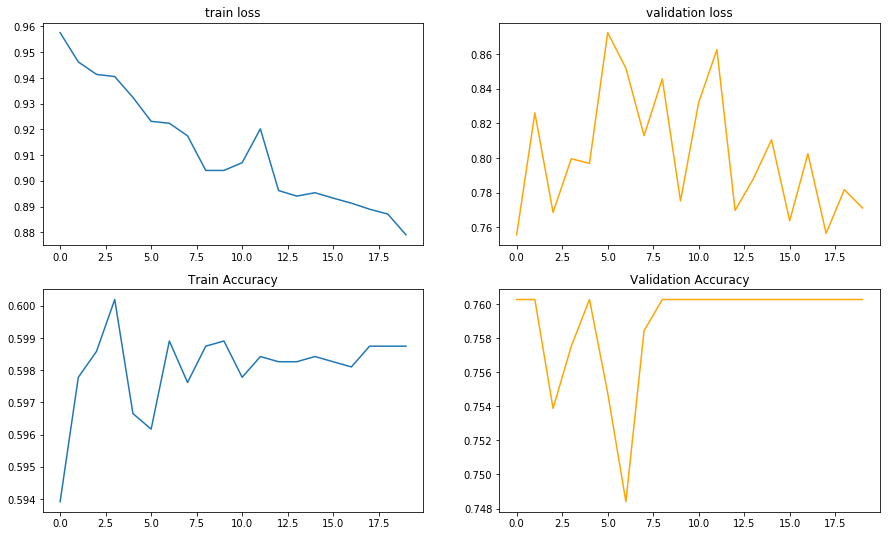

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])

In [107]:
# summarize history for loss
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,9))

axes[0,0].set_title('train loss')
axes[0,0].plot(history.history['loss'])
axes[0,1].set_title('validation loss')
axes[0,1].plot(history.history['val_loss'], c='orange')


axes[1,0].plot(history.history['acc'])
axes[1,1].plot(history.history['val_acc'], c='orange')
axes[1,0].set_title('Train Accuracy')
axes[1,1].set_title('Validation Accuracy')

plt.show()

history.history.keys()


In [108]:
y_predicted_train = predict_point_by_point(model, X_train)
y_predicted_test = predict_point_by_point(model, X_test)

In [109]:
labels_true = np.argmax(Y_test,axis=1)
labels_predicted_test = np.argmax(y_predicted_test,axis=1)

precision = metrics.precision_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)
recall = metrics.recall_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)
f1 = metrics.f1_score(y_true=labels_true, y_pred=labels_predicted_test, average=None)

print('|-------------|       ' + '             '.join('{}'.format(k[1]) for k in enumerate([0,1,2])))
print('| precision   :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(precision)) + '      (catched percent of positives)')
print('| recall      :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(recall)) + '       (correct percent of positives predictions)')
print('| f1-score    :     ' + '          '.join('{:.3}'.format(k[1]) for k in enumerate(f1)))

print ('combined f1 score (macro):  ' + str(metrics.f1_score(y_true=labels_true, y_pred=labels_predicted_test, average='macro')))
print ('accuracy:  ' + str(metrics.accuracy_score(y_true=labels_true, y_pred=labels_predicted_test) ))

|-------------|       0             1             2
| precision   :     0.722          0.0          0.0      (catched percent of positives)
| recall      :     1.0          0.0          0.0       (correct percent of positives predictions)
| f1-score    :     0.838          0.0          0.0
combined f1 score (macro):  0.2794545048066175
accuracy:  0.7217090069284064


/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/alex/anaconda3/anaconda/envs/py3.5.ITT/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


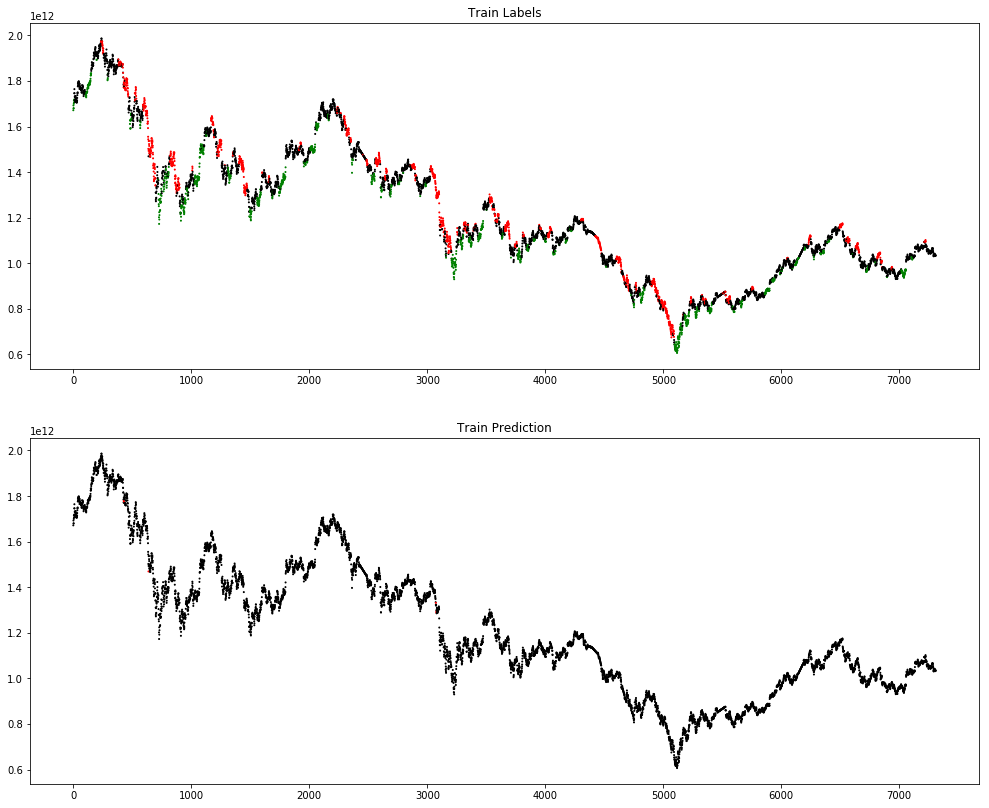

In [110]:

fig, [ax1,ax2] = plt.subplots(nrows=2, ncols=1, figsize=(17,14))

ax1.set_title("Train Labels")    
color_label = []
for p in Y_train:  
    if p[1] == 1:
        color = 'green'
    elif p[2] == 1:
        color = 'red' 
    else:
        color = 'black'
    color_label.append(color)
ax1.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=color_label, s=1)

ax2.set_title("Train Prediction")    
col2 = [] 
for p in y_predicted_train: 
    idx = np.argmax(p)
    if idx == 1:
        color = 'green'
    elif idx == 2:
        color = 'red' 
    else:
        color = 'black'
    col2.append(color)

ax2.scatter(range(y_tr_price.shape[0]),  y_tr_price, c=col2, s=1)
plt.show()



In [111]:
y_predicted_test[100:120,:]



array([[0.78658015, 0.15137327, 0.06204664],
       [0.7337078 , 0.1626301 , 0.10366213],
       [0.73595047, 0.15877192, 0.10527759],
       [0.7733521 , 0.14336985, 0.08327806],
       [0.72030455, 0.14400847, 0.13568696],
       [0.68340456, 0.14956343, 0.16703199],
       [0.53422695, 0.19419146, 0.27158168],
       [0.58893067, 0.15888345, 0.25218585],
       [0.5508323 , 0.15973029, 0.2894374 ],
       [0.54166603, 0.15693155, 0.30140245],
       [0.53031236, 0.1553322 , 0.31435546],
       [0.52783763, 0.15703914, 0.3151233 ],
       [0.5408729 , 0.15709756, 0.30202958],
       [0.53592116, 0.13593906, 0.3281398 ],
       [0.5149324 , 0.14358185, 0.3414858 ],
       [0.5167772 , 0.13760927, 0.3456135 ],
       [0.5253494 , 0.13749948, 0.33715117],
       [0.53347886, 0.13124783, 0.33527327],
       [0.48206744, 0.17241886, 0.34551373],
       [0.5040038 , 0.14218993, 0.35380632]], dtype=float32)

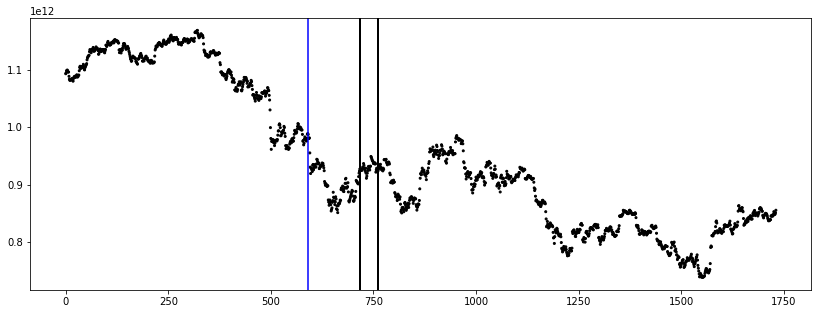

array([0.696309  , 0.27008247, 0.0336086 ], dtype=float32)

In [112]:
point = 590
start_of_train_position = point
position_on_plot = point + win_size
end_of_future_position = point + win_size + future


fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
col3 = []
for p in y_predicted_test: 
    idx = np.argmax(p)
    if idx == 1:
        color = 'green'
    elif idx == 2:
        color = 'red' 
    else:
        color = 'black'
    col3.append(color)


ax1.scatter(range(y_tst_price.shape[0]),  y_tst_price, c=col3, s=4)

ax1.axvline(position_on_plot, color=col3[position_on_plot], lw=2)
ax1.axvline(end_of_future_position, color=col3[position_on_plot], lw=2)
ax1.axvline(start_of_train_position, color='blue')

plt.show()

y_predicted_test[position_on_plot,:]

In [113]:
# add accuracy for predicted plot
# make win_size longer
# add data from several currencies 
# AWS


In [114]:

K.eval(model.optimizer.lr)


0.005